In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aroojzahra","key":"a872123416faa088384afea314a1ee79"}'}

In [ ]:
# create a kaggle directory

!mkdir ~/.kaggle


In [ ]:
# copy the kaggle.json to created the folder
!cp kaggle.json ~/.kaggle/

In [ ]:
# permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# to list all the datasets in kaggle
!kaggle datasets list

ref                                                       title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions              Student Performance Predictions                  9KB  2024-08-17 06:57:57           9465        207  0.9411765        
lainguyn123/student-performance-factors                   Student Performance Factors                     94KB  2024-09-02 10:53:57           2871         66  1.0              
hanaksoy/customer-purchasing-behaviors                    Customer Purchasing Behaviors                    1KB  2024-09-01 22:18:07           1799         24  1.0              
muhammadehsan02/olympic-summer-games-paris-2024           Olympic Summer Games - Paris 2024                3MB  202

In [ ]:
!kaggle datasets download -d mohit3430/haze1k


Dataset URL: https://www.kaggle.com/datasets/mohit3430/haze1k
License(s): unknown
100% 952M/953M [00:33<00:00, 26.7MB/s]
100% 953M/953M [00:33<00:00, 29.9MB/s]


In [ ]:
!unzip haze1k.zip -d ./haze1k


Archive:  haze1k.zip
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/001.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/002.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/003.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/004.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/005.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/006.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/007.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/008.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/009.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/010.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/011.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/012.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/input/013.png  
  inflating: ./haze1k/Distributed_haze1k/test_moderate/i

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os


In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            layers.append(nn.BatchNorm2d(out_channels))
            if dropout:
                layers.append(nn.Dropout(0.5))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.down1 = down_block(3, 64, batch_norm=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, batch_norm=False)

        self.up1 = up_block(512, 512, dropout=True)
        self.up2 = up_block(1024, 512, dropout=True)
        self.up3 = up_block(1024, 512, dropout=True)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoder (downsampling)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Decoder (upsampling)
        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return torch.tanh(u8)


In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super(PatchDiscriminator, self).__init__()

        def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            conv_block(6, 64, batch_norm=False),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class HazeDataset(Dataset):
    def __init__(self, hazy_dir, clear_dir, transform=None):
        self.hazy_images = sorted(os.listdir(hazy_dir))
        self.clear_images = sorted(os.listdir(clear_dir))
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.transform = transform

    def __len__(self):
        return len(self.hazy_images)

    def __getitem__(self, idx):
        hazy_img_path = os.path.join(self.hazy_dir, self.hazy_images[idx])
        clear_img_path = os.path.join(self.clear_dir, self.clear_images[idx])

        hazy_image = transforms.ToTensor()(Image.open(hazy_img_path))
        clear_image = transforms.ToTensor()(Image.open(clear_img_path))

        if self.transform:
            hazy_image = self.transform(hazy_image)
            clear_image = self.transform(clear_image)

        return hazy_image, clear_image


In [ ]:
# Hyperparameters
lr = 0.0002
batch_size = 4
epochs = 100

# Directories
hazy_dir = "/content/haze1k/Distributed_haze1k/test_moderate/input"
clear_dir = "/content/haze1k/Distributed_haze1k/test_moderate/target"

# Data loader
dataset = HazeDataset(hazy_dir, clear_dir, transform=transforms.Resize((256, 256)))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [58]:
# Initialize models
# generator = UNetGenerator().cuda()
# discriminator = PatchDiscriminator().cuda()

generator = UNetGenerator()
discriminator = PatchDiscriminator()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Losses
adversarial_loss = nn.BCEWithLogitsLoss()
pixelwise_loss = nn.L1Loss()

# Labels
real_label = 1.
fake_label = 0.


In [60]:
for epoch in range(epochs):
    for i, (hazy_imgs, clear_imgs) in enumerate(dataloader):
        hazy_imgs = hazy_imgs
        clear_imgs = clear_imgs

        # Train Discriminator
        optimizer_D.zero_grad()

        real_output = discriminator(torch.cat([hazy_imgs, clear_imgs], 1))
        real_loss = adversarial_loss(real_output, torch.full_like(real_output, real_label))

        fake_imgs = generator(hazy_imgs)
        fake_output = discriminator(torch.cat([hazy_imgs, fake_imgs.detach()], 1))
        fake_loss = adversarial_loss(fake_output, torch.full_like(fake_output, fake_label))

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        fake_output = discriminator(torch.cat([hazy_imgs, fake_imgs], 1))
        g_loss = adversarial_loss(fake_output, torch.full_like(fake_output, real_label))
        pixel_loss = pixelwise_loss(fake_imgs, clear_imgs)

        g_total_loss = g_loss + pixel_loss * 100  # Weighted pixel-wise loss
        g_total_loss.backward()
        optimizer_G.step()

        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_total_loss.item()}]")

    # Save generated images every epoch
    if epoch % 10 == 0:
        save_image(fake_imgs, f"generated_epoch_{epoch}.png", normalize=True)


[Epoch 0/100] [Batch 0/12] [D loss: 0.7024487257003784] [G loss: 63.107460021972656]
[Epoch 0/100] [Batch 1/12] [D loss: 0.5995549559593201] [G loss: 56.17238998413086]
[Epoch 0/100] [Batch 2/12] [D loss: 0.5520408153533936] [G loss: 49.4044189453125]
[Epoch 0/100] [Batch 3/12] [D loss: 0.5540406107902527] [G loss: 43.122291564941406]
[Epoch 0/100] [Batch 4/12] [D loss: 0.40625810623168945] [G loss: 39.77116394042969]
[Epoch 0/100] [Batch 5/12] [D loss: 0.3656536340713501] [G loss: 36.00585174560547]
[Epoch 0/100] [Batch 6/12] [D loss: 0.2790527939796448] [G loss: 31.931264877319336]
[Epoch 0/100] [Batch 7/12] [D loss: 0.2785155475139618] [G loss: 30.508214950561523]
[Epoch 0/100] [Batch 8/12] [D loss: 0.2384168803691864] [G loss: 27.972827911376953]
[Epoch 0/100] [Batch 9/12] [D loss: 0.24968458712100983] [G loss: 25.86103630065918]
[Epoch 0/100] [Batch 10/12] [D loss: 0.21540950238704681] [G loss: 23.36215591430664]
[Epoch 0/100] [Batch 11/12] [D loss: 0.20106208324432373] [G loss: 2

In [61]:
# Save the trained models
torch.save(generator.state_dict(), 'unet_generator.pth')
torch.save(discriminator.state_dict(), 'patch_discriminator.pth')


In [63]:
# Initialize models
generator = UNetGenerator()
discriminator = PatchDiscriminator()

# Load saved model weights
generator.load_state_dict(torch.load('unet_generator.pth'))
discriminator.load_state_dict(torch.load('patch_discriminator.pth'))

# Set models to evaluation mode
generator.eval()
discriminator.eval()


<ipython-input-63-0516a5d80119>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('unet_generator.pth'))
<ipython-input-63-0516a5d80119>:

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)

In [64]:
from PIL import Image
import torchvision.transforms as transforms

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to match input size
        transforms.ToTensor(),  # Convert to tensor
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension and move to GPU

image = load_image('/content/haze1.jpg')


In [65]:
with torch.no_grad():
    output = generator(image)

# Post-process and save the output image
from torchvision.utils import save_image
save_image(output, 'output_image.png', normalize=True)


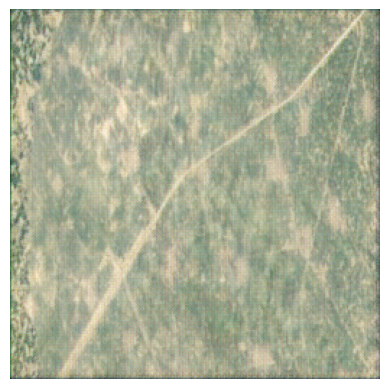

In [66]:
from PIL import Image
import matplotlib.pyplot as plt

def view_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

view_image('output_image.png')
